<div style="text-align: center;">
  <h1><strong>HANDWRITTEN SIGNATURE VERIFICATION </strong></h1>
</div>


Bài toán dùng phân loại nhị phân để so sánh mẫu chữ ký mới có giống với mẫu chữ ký đã lưu trong CSDL không

### **Tiền xử lý dữ liệu**
* Đọc ảnh chữ ký từ thư mục.
* Chuyển ảnh về grayscale (ảnh đen trắng).
* Resize ảnh về 128 x 128 (để phù hợp với mô hình CNN sau này).
* Chuẩn hóa ảnh về khoảng [0,1] để giúp mô hình học tốt hơn.

In [ ]:
# Xác định xem đã truy cập đến thư mục dataset được chưa
import os

# Đường dẫn thư mục chính
dataset_path = "./Dataset/"  # Thay bằng đường dẫn thực tế

# Duyệt qua từng thư mục con (dataset1, dataset2,...)
for dataset in sorted(os.listdir(dataset_path)):
    dataset_folder = os.path.join(dataset_path, dataset)
    if os.path.isdir(dataset_folder):  # Kiểm tra nếu là thư mục
        forge_path = os.path.join(dataset_folder, "forge")
        real_path = os.path.join(dataset_folder, "real")

        # Lấy danh sách ảnh trong từng thư mục
        forge_images = [os.path.join(forge_path, img) for img in os.listdir(forge_path)]
        real_images = [os.path.join(real_path, img) for img in os.listdir(real_path)] if os.path.exists(real_path) else []

        print(f" {dataset} - {len(real_images)} real, {len(forge_images)} forged")

# Chọn một ảnh để thử tiền xử lý
image_path = real_images[0]  # Lấy ảnh thật đầu tiên
print("Sample image path:", image_path)

📂 dataset1 - 60 real, 98 forged
📂 dataset2 - 60 real, 60 forged
📂 dataset3 - 150 real, 150 forged
📂 dataset4 - 90 real, 90 forged
Sample image path: ./Dataset/dataset4\real\00201002.png


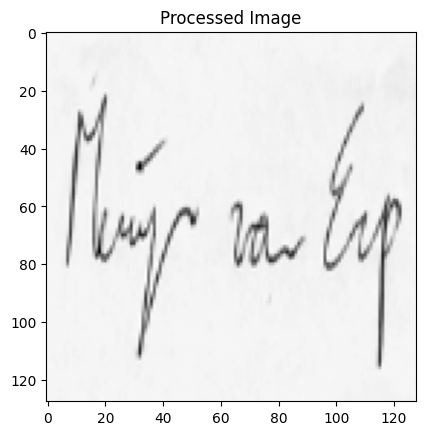

In [ ]:
# Tiền xử lý hình ảnh

import cv2 # openCV xử lý hình ảnh
import numpy as np # mảng



# Định nghĩa kích thước ảnh
IMG_SIZE = (128, 128)

def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, IMG_SIZE) / 255.0
        img = np.expand_dims(img, axis=-1)
    return img

# Ví dụ: Load một ảnh để kiểm tra
sample_path = "./Dataset/dataset1/real/00100001.png"  # Thay đường dẫn thực tế
processed_img = load_and_preprocess_image(sample_path)

# Hiển thị ảnh sau khi tiền xử lý
import matplotlib.pyplot as plt
plt.imshow(processed_img.squeeze(), cmap="gray")
plt.title("Processed Image")
plt.show()


### **Load toàn bộ dữ liệu và tạo tập huấn luyện**

Thực hiện duyệt dataset và chia thành tập huấn luyện: train 80%, test 20%.

In [ ]:
import os  #Thao tác với hệ thống file và thư mục
import numpy as np  #Dùng để xử lý mảng dữ liệu số học (đặc biệt là ảnh)
import tensorflow as tf  #Thư viện chính để xây dựng và huấn luyện mô hình AI
from tensorflow.keras import layers, Model  #Module chứa các công cụ để xây dựng mô hình deep learning
from sklearn.model_selection import train_test_split  #Dùng để chia tập dữ liệu thành tập huấn luyện và kiểm tra
from tensorflow.keras.preprocessing.image import load_img, img_to_array #Hỗ trợ tải và chuyển đổi ảnh sang dạng mảng số.
import logging  # Ghi lại thông tin quá trình chạy chương trình vào file log
from datetime import datetime   #Hỗ trợ xử lý ngày giờ

# Cấu hình logging
logging.basicConfig(
    filename='training_log.log',  # Tên file log
    level=logging.INFO,           # Mức độ log (INFO, DEBUG, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(message)s',  # Định dạng log
    filemode='a'                  # Ghi tiếp vào file log (append)
)

# Định nghĩa kích thước ảnh
IMG_SIZE = (128, 128)

# Hàm để tải và tiền xử lý ảnh
def load_and_preprocess_image(image_path, target_size=IMG_SIZE):
    img = load_img(image_path, color_mode="grayscale", target_size=target_size)
    img = img_to_array(img) / 255.0  #chuyển ảnh thành mảng numpy [0,1]
    return img

# Hàm để tải dữ liệu từ thư mục
def load_data_from_folder(folder_path, label):
    images = []
    labels = []
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = load_and_preprocess_image(img_path)
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Hàm để tải toàn bộ dữ liệu
def load_dataset(dataset_path):
    real_images, real_labels = [], []
    forge_images, forge_labels = [], []
    
    for dataset in sorted(os.listdir(dataset_path)):
        dataset_folder = os.path.join(dataset_path, dataset)
        if os.path.isdir(dataset_folder):
            forge_path = os.path.join(dataset_folder, "forge")
            real_path = os.path.join(dataset_folder, "real")
            
            if os.path.exists(forge_path):
                forge_imgs, forge_lbls = load_data_from_folder(forge_path, label=0)
                forge_images.extend(forge_imgs)
                forge_labels.extend(forge_lbls)
            
            if os.path.exists(real_path):
                real_imgs, real_lbls = load_data_from_folder(real_path, label=1)
                real_images.extend(real_imgs)
                real_labels.extend(real_lbls)
    
    return np.array(real_images), np.array(real_labels), np.array(forge_images), np.array(forge_labels)

# Tải dữ liệu
real_images, real_labels, forge_images, forge_labels = load_dataset("./Dataset")

# Chia tập huấn luyện và kiểm tra
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(real_images, real_labels, test_size=0.2, random_state=42)
X_train_forge, X_test_forge, y_train_forge, y_test_forge = train_test_split(forge_images, forge_labels, test_size=0.2, random_state=42)

# Kết hợp dữ liệu
X_train = np.concatenate([X_train_real, X_train_forge])
y_train = np.concatenate([y_train_real, y_train_forge])
X_test = np.concatenate([X_test_real, X_test_forge])
y_test = np.concatenate([y_test_real, y_test_forge])

### **Xây dựng và huấn luyện mô hình**

In [ ]:
from tensorflow.keras.regularizers import l2  #Regularization để giảm overfitting bằng cách thêm một hình phạt vào trọng số lớn.
from tensorflow.keras.callbacks import EarlyStopping  #Dừng quá trình huấn luyện sớm nếu mô hình không cải thiện trong một số epoch nhất định.

# Định nghĩa mạng CNN
def build_cnn_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation="relu")(inputs) #Lớp tích chập với 32 bộ lọc kích thước 3×3, sử dụng hàm kích hoạt ReLU để học đặc trưng từ ảnh đầu vào.
    x = layers.MaxPooling2D((2, 2))(x)   #Lớp pooling giúp giảm kích thước đầu ra và tránh overfitting.
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)   #Biến đổi dữ liệu từ 2D thành 1D để đưa vào Dense layer.
    x = layers.Dense(128, activation="relu", kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.6)(x)  # Tắt ngẫu nhiên 60% neuron để giảm overfitting.
    outputs = layers.Dense(1, activation="sigmoid")(x)  #Đầu ra với 1 neuron, dùng hàm sigmoid cho bài toán phân loại nhị phân.
    return Model(inputs, outputs)

# Xây dựng và biên dịch mô hình
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 1)
cnn_model = build_cnn_model(input_shape)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # learning rate nhỏ (0.0001) để tối ưu mô hình
cnn_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])


# Khởi tạo Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Theo dõi validation loss
    patience=5,  # Dừng nếu sau 5 epoch loss không cải thiện
    restore_best_weights=True  # Khôi phục trọng số tốt nhất
)

# Huấn luyện mô hình với Early Stopping
logging.info("Bắt đầu huấn luyện mô hình")
history = cnn_model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping])


# Đánh giá mô hình
logging.info("Đánh giá mô hình trên tập test")
loss, accuracy = cnn_model.evaluate(X_test, y_test)
logging.info(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

# Lưu kết quả từ lịch sử huấn luyện
for epoch in range(len(history.history['accuracy'])):
    train_accuracy = history.history['accuracy'][epoch]
    val_accuracy = history.history['val_accuracy'][epoch]
    train_loss = history.history['loss'][epoch]
    val_loss = history.history['val_loss'][epoch]
    
    logging.info(
        f"Epoch {epoch + 1}: "
        f"Train Accuracy: {train_accuracy * 100:.2f}%, "
        f"Validation Accuracy: {val_accuracy * 100:.2f}%, "
        f"Train Loss: {train_loss:.4f}, "
        f"Validation Loss: {val_loss:.4f}"
    )
# Lưu toàn bộ mô hình
cnn_model.save("my_model.keras")



Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.5021 - loss: 3.0712 - val_accuracy: 0.5263 - val_loss: 2.5674
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.5672 - loss: 2.4254 - val_accuracy: 0.6053 - val_loss: 2.0465
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.5940 - loss: 1.9394 - val_accuracy: 0.5263 - val_loss: 1.6588
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.5428 - loss: 1.5859 - val_accuracy: 0.6250 - val_loss: 1.3867
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.6167 - loss: 1.3305 - val_accuracy: 0.6184 - val_loss: 1.1870
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.6051 - loss: 1.1506 - val_accuracy: 0.6382 - val_loss: 1.0400
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.6371 - loss: 0.9905 - val_accuracy: 0.5855 - val_loss: 0.9546
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.6501 - loss: 0.9150 - val_accuracy: 0.

### **Đánh giá mô hình**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7388 - loss: 0.6225
Test Loss: 0.5834, Test Accuracy: 77.63%


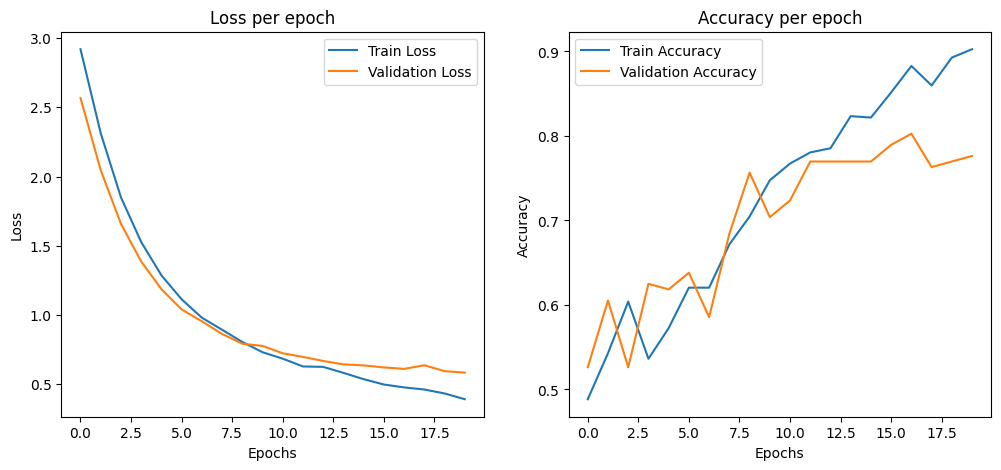

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


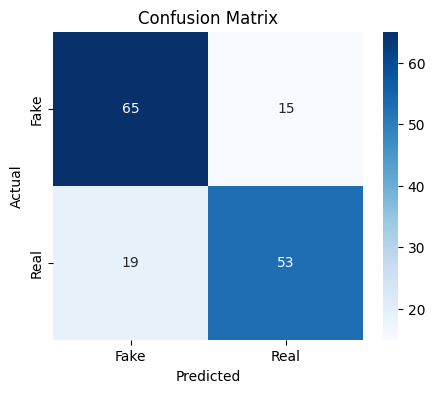

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
              precision    recall  f1-score   support

        Fake       0.77      0.81      0.79        80
        Real       0.78      0.74      0.76        72

    accuracy                           0.78       152
   macro avg       0.78      0.77      0.77       152
weighted avg       0.78      0.78      0.78       152



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns #ma trận nhầm lẫn
from sklearn.metrics import confusion_matrix, classification_report #in báo cáo phân loại

# Đánh giá mô hình trên tập test
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

# Vẽ biểu đồ quá trình huấn luyện
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Vẽ loss
    axs[0].plot(history.history["loss"], label="Train Loss")
    axs[0].plot(history.history["val_loss"], label="Validation Loss")
    axs[0].set_title("Loss per epoch")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    

    # Vẽ accuracy
    axs[1].plot(history.history["accuracy"], label="Train Accuracy")
    axs[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axs[1].set_title("Accuracy per epoch")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.show()
    # Nếu train loss giảm mà val loss tăng thì có overfitting.

# Vẽ ma trận nhầm lẫn
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Hiển thị báo cáo phân loại
def print_classification_report(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))
    
        

# Gọi các hàm đánh giá sau khi huấn luyện
evaluate_model(cnn_model, X_test, y_test)
plot_training_history(history)
plot_confusion_matrix(cnn_model, X_test, y_test)
print_classification_report(cnn_model, X_test, y_test)


* Precision (độ chính xác) Tỷ lệ dự đoán đúng trên tổng số dự đoán của từng lớp.
* Recall (độ nhạy) Tỷ lệ dự đoán đúng trên tổng số mẫu thực tế của từng lớp.
* F1-score (độ cân bằng Precision và Recall) Trung bình điều hòa của Precision và Recall.
* Support (số lượng mẫu trong mỗi lớp)

### **Thử với dữ liệu thực tế**

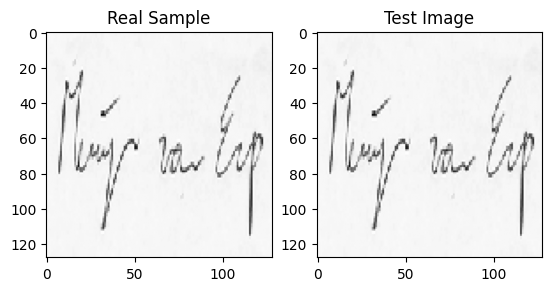

In [72]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Định nghĩa kích thước ảnh
IMG_SIZE = (128, 128)

# Hàm để tải và tiền xử lý ảnh
def load_and_preprocess_image(image_path, target_size=IMG_SIZE):
    img = load_img(image_path, color_mode="grayscale", target_size=target_size)
    img = img_to_array(img) / 255.0
    return img

# Tải mẫu thực tế (Real Sample)
real_sample_path = "./Dataset/dataset1/real/00100001.png"
real_sample = load_and_preprocess_image(real_sample_path)

# Tải ảnh test (Test Image) 
test_image_path = "./Dataset/dataset1/real/00100001.png"
test_image = load_and_preprocess_image(test_image_path)

# Chuẩn bị dữ liệu đầu vào cho mô hình
# Kết hợp mẫu thực tế và ảnh test thành một batch
input_data = np.array([real_sample, test_image])

import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(real_sample.squeeze(), cmap="gray")
plt.title("Real Sample")

plt.subplot(1, 2, 2)
plt.imshow(test_image.squeeze(), cmap="gray")
plt.title("Test Image")

plt.show()


In [73]:
# Dự đoán nhãn cho dữ liệu đầu vào
from tensorflow.keras.models import load_model

# Tải lại mô hình
cnn_model = load_model('my_model.keras')

predictions = cnn_model.predict(input_data)

# Lấy xác suất dự đoán cho ảnh test
test_prediction = predictions[1][0]  # Xác suất dự đoán cho ảnh test
test_label = "Real" if test_prediction > 0.5 else "Forge"

print(f"Xác suất dự đoán Real Sample: {predictions[0][0]:.4f}")
print(f"Xác suất dự đoán Test Image: {predictions[1][0]:.4f}")

# Hiển thị kết quả
print(f"Ảnh test: {test_image_path}")
print(f"Dự đoán: {test_label}, Xác suất: {test_prediction:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Xác suất dự đoán Real Sample: 0.8938
Xác suất dự đoán Test Image: 0.8938
Ảnh test: ./Dataset/dataset1/real/00100001.png
Dự đoán: Real, Xác suất: 0.8938
